In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.8.0


In [ ]:
autotune = tf.data.experimental.AUTOTUNE
batch = 32 * strategy.num_replicas_in_sync
target = [176, 208]
epochs = 100
num_classes=4

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train",
    validation_split=0.2,
    subset="training",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train",
    validation_split=0.2,
    subset="validation",
    seed=10,
    image_size=target,
    batch_size=batch,
    color_mode="rgb"
)

Found 1861 files belonging to 2 classes.
Using 1489 files for training.
Found 1861 files belonging to 2 classes.
Using 372 files for validation.


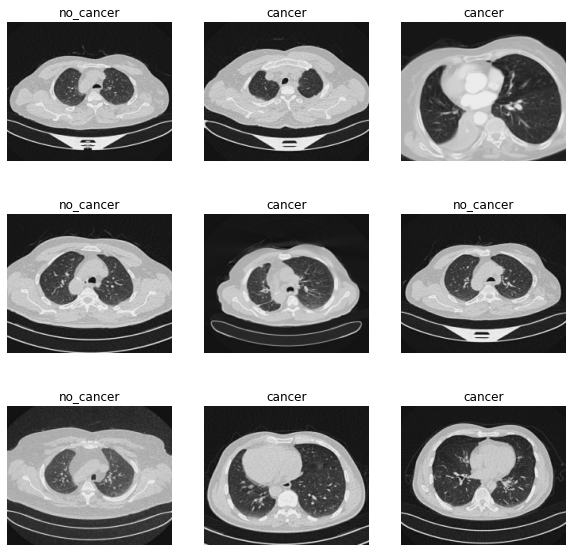

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #Greyscale
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

FileNotFoundError: ignored

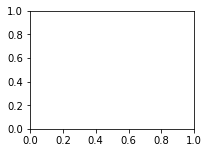

In [ ]:
class_names = ['cancer', 'no_cancer']
path="/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train/"
import subprocess
import re

plt.figure(figsize=(10,10))
#subplot(r,c) provide the no. of rows and columns
#f, axarr = plt.subplots(4,3)
i=0
j=0

for cls in class_names:
    result = subprocess.run(['ls', path+cls], stdout=subprocess.PIPE)
    res=result.stdout.decode('utf-8')
    res=re.sub(r'\n', ' ', res)
    file_list=res.split(' ')
    j=0
    for x in range(0, 3):
        # (nrows, ncols, index out of entire array of images)
        ax=plt.subplot(4,3,(3*i)+j+1)
        img=plt.imread(path+cls+'/'+file_list[i])
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        j+=1
    i+=1

In [ ]:
# assigning one hot encoding of labels to train and val dataset
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_dataset = train_dataset.map(one_hot_label, num_parallel_calls=autotune)
val_dataset = val_dataset.map(one_hot_label, num_parallel_calls=autotune)

In [ ]:
# preprocessing stage => rescaling pixel values of images
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)

In [ ]:
num_images_per_class = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/train/" + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
num_images_per_class

[938, 925]

In [ ]:
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight(class_weight="balanced",classes=[0,1], y=np.asarray(y_train))
class_weights
# these weights will be used in fit procedure to compute class-weighted loss

array([0.99307036, 1.00702703])

In [ ]:
# Create the base model from the pre-trained ResNet50V2 architecture
base_model = tf.keras.applications.ResNet50V2(input_shape=(*target, 3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


94683136/94668760 [==============================] - 1s 0us/step
(32, 6, 7, 2048)


In [ ]:
# freezing base_model layers
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 90, 106, 64)  0           ['conv1_conv[0][0]']    

In [ ]:
# Global average pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
# Classification head layer
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 8.2 MB/s 


In [ ]:
# TL model with frozen base
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow_addons as tfa

inputs = tf.keras.Input(shape=(*target, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)        #rescaling
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# using AUC and Weighted-F1Score as primary metrics
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                             

In [ ]:
# Callbacks
import numpy as np
from keras.callbacks import Callback

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("dementia_model.h5",
                                                    save_best_only=True, monitor="val_loss", mode='min')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True, monitor="val_loss", mode='min')
cb=[checkpoint_cb, early_stopping_cb]
# using 2 callbacks;
# save best selected model with least val_loss,
# terminate training run if val_loss doesnt change for 10 epochs

In [ ]:
# Validation scores before training
model.evaluate(val_dataset)

12/12 [==============================] - 36s 695ms/step - loss: 1.5669 - auc: 0.4785 - f1: 0.2927 - acc: 0.2285


[1.5669289827346802,
 0.47853314876556396,
 0.2926773428916931,
 0.22849462926387787]

In [ ]:
# run_1 (training classification head after feature extraction)
history1 = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4,
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1]

                                  })

Epoch 1/50
47/47 [==============================] - 117s 2s/step - loss: 1.6428 - auc: 0.5062 - f1: 0.3066 - acc: 0.2411 - val_loss: 1.5312 - val_auc: 0.5018 - val_f1: 0.3001 - val_acc: 0.2392
Epoch 2/50
47/47 [==============================] - 6s 123ms/step - loss: 1.5854 - auc: 0.5297 - f1: 0.3167 - acc: 0.2492 - val_loss: 1.4963 - val_auc: 0.5253 - val_f1: 0.3159 - val_acc: 0.2581
Epoch 3/50
47/47 [==============================] - 6s 124ms/step - loss: 1.5774 - auc: 0.5347 - f1: 0.3303 - acc: 0.2666 - val_loss: 1.4629 - val_auc: 0.5484 - val_f1: 0.3287 - val_acc: 0.2769
Epoch 4/50
47/47 [==============================] - 6s 125ms/step - loss: 1.5539 - auc: 0.5517 - f1: 0.3278 - acc: 0.2653 - val_loss: 1.4304 - val_auc: 0.5710 - val_f1: 0.3390 - val_acc: 0.2903
Epoch 5/50
47/47 [==============================] - 6s 122ms/step - loss: 1.5044 - auc: 0.5776 - f1: 0.3574 - acc: 0.2982 - val_loss: 1.3993 - val_auc: 0.5927 - val_f1: 0.3577 - val_acc: 0.3118
Epoch 6/50
47/47 [=============

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 125

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# 65 layers are set trainable in bottom up manner from classification head
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=[AUC(name="auc"),
                                                                            tfa.metrics.F1Score(name="f1", num_classes=4,
                                                                            average="weighted"),
                                                                            CategoricalAccuracy(name="acc")
                                                                            ])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 176, 208, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 6, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                             

In [ ]:
# validation scores before training
model.evaluate(val_dataset)

12/12 [==============================] - 3s 72ms/step - loss: 0.7643 - auc: 0.8719 - f1: 0.5771 - acc: 0.5780


[0.7643269300460815,
 0.8719180226325989,
 0.5771175622940063,
 0.5779569745063782]

In [ ]:
# run_2 (fine tuning the pretrained layers)
history2 = model.fit(train_dataset,
                    epochs=70,
                    validation_data=val_dataset, verbose=1, callbacks=cb, use_multiprocessing=True, workers=4,
                    class_weight={
                                    0: class_weights[0],
                                    1: class_weights[1]

                                  })

Epoch 1/70
47/47 [==============================] - 8s 155ms/step - loss: 5.9463e-04 - auc: 1.0000 - f1: 1.0000 - acc: 1.0000 - val_loss: 0.0383 - val_auc: 0.9998 - val_f1: 0.9866 - val_acc: 0.9866
Epoch 2/70
47/47 [==============================] - 8s 153ms/step - loss: 8.1486e-04 - auc: 1.0000 - f1: 1.0000 - acc: 1.0000 - val_loss: 0.0378 - val_auc: 0.9998 - val_f1: 0.9866 - val_acc: 0.9866
Epoch 3/70
47/47 [==============================] - 8s 150ms/step - loss: 6.0819e-04 - auc: 1.0000 - f1: 1.0000 - acc: 1.0000 - val_loss: 0.0396 - val_auc: 0.9997 - val_f1: 0.9866 - val_acc: 0.9866
Epoch 4/70
47/47 [==============================] - 8s 153ms/step - loss: 4.8948e-04 - auc: 1.0000 - f1: 1.0000 - acc: 1.0000 - val_loss: 0.0373 - val_auc: 0.9998 - val_f1: 0.9866 - val_acc: 0.9866
Epoch 5/70
47/47 [==============================] - 8s 152ms/step - loss: 4.8030e-04 - auc: 1.0000 - f1: 1.0000 - acc: 1.0000 - val_loss: 0.0370 - val_auc: 0.9998 - val_f1: 0.9866 - val_acc: 0.9866
Epoch 6/70

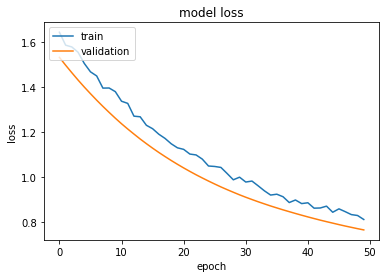

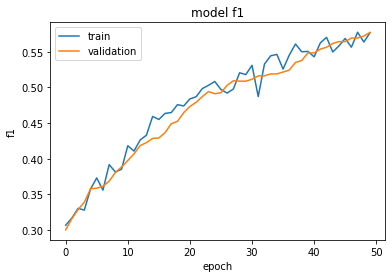

In [ ]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history1.history['f1'])
plt.plot(history1.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

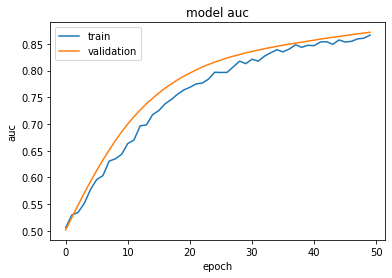

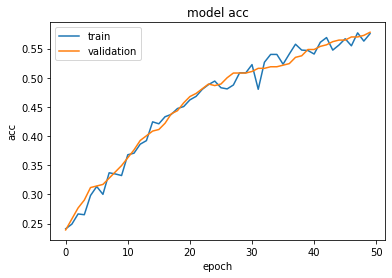

In [ ]:
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

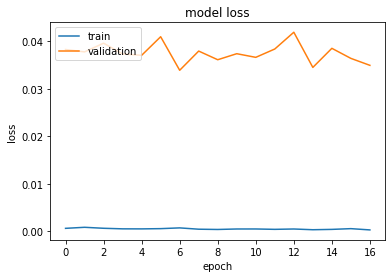

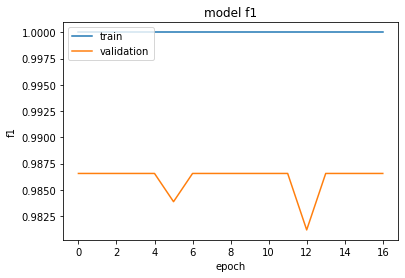

In [ ]:
# Plotting train_loss and val_loss wrt epochs
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['f1'])
plt.plot(history2.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

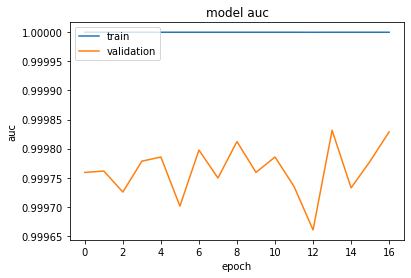

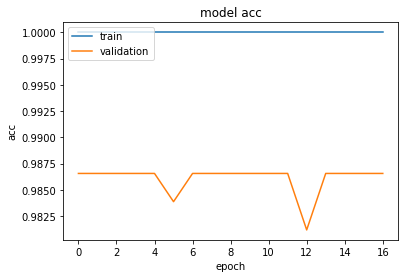

In [ ]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LUNGCANCER/Lung_data_new/test",
    image_size=target,
    batch_size=batch,
    shuffle=False,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=autotune)
test_ds = test_ds.cache().prefetch(buffer_size=autotune)

Found 750 files belonging to 2 classes.


In [ ]:
model.evaluate(test_ds)

24/24 [==============================] - 67s 3s/step - loss: 0.0675 - auc: 0.9969 - f1: 0.9840 - acc: 0.9840


[0.06747951358556747,
 0.9969096183776855,
 0.9839878082275391,
 0.984000027179718]

In [ ]:
predictions=model.predict(test_ds)

In [ ]:
# list of number of images belonging to each class in test directory
test_images = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/LUNGCANCER/Data/test/" + label
    test_images.append(len([name for name in os.listdir(dir_name)]))
test_images

[191, 156]

In [ ]:
# targets list
targets=[]
for i in range(0, len(test_images)):
    targets+=[i]*test_images[i]
targets=np.asarray(targets)
test_images, class_names, targets

([191, 156],
 ['cancer', 'no_cancer'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.asarray(targets), np.argmax(predictions, axis=1), target_names=class_names))

ValueError: ignored